# HappyCustomer - An Apziva Project

By Samuel Alter

This project centers on a customer survey dataset from a delivery company. The dataset consists of the following:
* `Y`: The target attribute, indicating whether the customer noted their happiness or unhappiness
* `X1`: Order was delivered on time
* `X2`: Contents of the order was as expected
* `X3`: I ordered everything that I wanted to order
* `X4`: I paid a good price for my order
* `X5`: I am satisfied with my courier
* `X6`: The app makes ordering easy for me

Attributes `X1` through `X6` are on a 1 to 5 scale, with 5 indicating most agreement with the statement.

The goals of this project are to train a model that predicts whether a customer is happy or not, based on their answers to the survey. Specifically, I am to reach 73% accuracy or higher with my modeling, or explain why my solution is superior.

A stretch goal would be to determine which features are more important when predicting a customer's happiness. What is the minimal set of attributes or features that would preserve the most information about the problem, while at the same time increasing predictability? The aim here is to see if any question can be eliminated in the next survey round.

The statistical analysis of the features can be found in the [Statistical Modeling](#statistical_modeling) section at the end of this document.

## Setup and Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv('../data/ACME-HappinessSurvey2020.csv')
df.sample(5)

Let's rename the columns to make them more intuitive.

In [ ]:
df.rename(columns={'Y':'y',
                   'X1':'a_time',
                   'X2':'b_contents',
                   'X3':'c_complete',
                   'X4':'d_price',
                   'X5':'e_courier',
                   'X6':'f_app'},inplace=True)

# using alphabet prefixes to ensure correct order of columns

## EDA

In [ ]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset")

In [ ]:
df.describe()

It seems like most of the participants in the survey were happy about the time it took to receive the order and app experience, but all of this will require more exploration.

In [ ]:
df['y'].value_counts()

In [ ]:
# data labels
x=[0,1]
y=[df['y'].value_counts()[0],df['y'].value_counts()[1]]

plt.figure(figsize=(6, 4))
ax=sns.countplot(data=df, x='y',zorder=3,)
plt.title('Distribution of Customer Happiness in Target (y)')
plt.xlabel('Target Values\n0: Unhappy, 1: Happy')
plt.ylabel('Count')
ax.yaxis.grid(True,zorder=0)
for i in range(len(x)):
    plt.text(i, y[i], y[i], ha = 'center')
plt.savefig('../figs/1_ydistribution.pdf')
plt.savefig('../figs/1_ydistribution.png')
plt.show()

In [ ]:
print(f"In the dataset, {round(df['y'].value_counts()[1]/df['y'].shape[0]*100,2)}% of respondents were happy,\nwhile {round(df['y'].value_counts()[0]/df['y'].shape[0]*100,0)}% of respondents were unhappy.")

In [ ]:
# prepare X data for plotting
col_list=[]

for i in df.columns:
    col_list.append(i)
    
col_list.remove('y')

df_melted=df.melt(value_vars=col_list,var_name='Variable',value_name='Value')

# calculate mean value per variable
mean_values=df_melted.groupby('Variable')['Value'].mean().to_dict()

In [ ]:
mean_values

In [ ]:
# create custom labels for following figure
labels=[f"{variable}: {mean_values[variable]:.2f}" for variable in mean_values.keys()]
labels

In [ ]:
df_melted['Variable'].value_counts()

In [ ]:
xlabs=['Delivery Time',
       'Contents of Order',
       'Order Completeness',
       'Price for Order',
       'Satisfaction with Courier',
       'Satisfaction with App Experience']

In [ ]:
# plot distribution of survey results

plt.figure(figsize=(12,8))
ax=sns.countplot(data=df_melted,x='Variable',hue='Value')
plt.suptitle('Count of Survey Results for Each Survey Question\n1 being least satisfied and 5 being most satisfied')
plt.xlabel('Survey Question')
plt.ylabel('Count')
ax.set_axisbelow(True)
ax.yaxis.grid(True,which='major')
ax.set_xticklabels(xlabs)
plt.xticks(rotation=30)
plt.legend(title='Response',loc='upper left')
plt.tight_layout()
plt.savefig('./figs/1_xdistribution.pdf')
plt.savefig('./figs/1_xdistribution.png')
plt.show()

In [ ]:
# setup labels for mean values

mean_values=df_melted.groupby('Variable')['Value'].mean()
mean_values=mean_values.round(decimals=2)
mean_values

In [ ]:
# data labels
x=[i for i in np.arange(6)]
y=[mean_values[i] for i in np.arange(6)]

In [ ]:
plt.figure(figsize=(10,6))
ax=sns.barplot(data=df_melted,x='Variable',y='Value',ci=None,color='coral')
plt.tight_layout(pad=10)
# plot labels
for i in range(len(x)):
    plt.text(i, y[i], y[i], ha='center')
ax.set_xticklabels(xlabs,rotation=30)
ax.set_title('Mean Response to Survey Question')
ax.set_ylabel('Mean Response')
ax.set_xlabel('Survey Question')
plt.savefig('./figs/1_xmeandistribution.pdf')
plt.savefig('./figs/1_xmeandistribution.png')
plt.show()

The delivery time and app experience had the highest mean satisfaction in the survey, with the contents having the lowest overall.

### Correlation Matrix

In [ ]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f,ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, annot=True,
            cbar_kws={"shrink": .5})
plt.title('Correlation Matrix\nHigher absolute value indicates stronger correlation')
plt.tight_layout()

# save fig
plt.savefig('./figs/1_corrmatrix.pdf')
plt.savefig('./figs/1_corrmatrix.png')

The results of the correlation matrix shows that generally speaking, if one aspect of the experience is positive, the customer will rate others positive as well. One interesting correlation to highlight is the courier and time are connected, which makes sense: the courier is the person that gives you your order, and if the courier is on time you probably will rate the courier highly too.

## Modeling

Remember, our target accuracy is to be greater than or equal to 73%. The accuracy floor we need to surpass is 55%, which is the amount of happy customers in the dataset.

Our target variable is `y`. Our independent variables, or features, are `X1`-`X6` (delivery time, contents of order, order completeness, price for order, satisfaction with courier, and satisfaction with app experience, respectively)

### Note on modeling method

Our target variable is binary in that the customer notes whether they are happy or not. Thus, we will be using **logistic regression** models as they will predict a yes or no, 0 or 1, happy or not happy.

### Setting up `X` and `y`

In [ ]:
X=df.drop(['y'],axis=1).to_numpy() # independent variables
y=df[[col for col in df.columns if col == 'y']].to_numpy() # dependent variable

In [ ]:
print(type(X))
print(type(y))

In [ ]:
print(f"The shape of the independent variables: {X.shape}")
print(f"The shape of the dependent variable:   {y.shape}")

Now we must transform the dependent variable into a vector to prepare it for modeling.

In [ ]:
y=y.reshape(-1)
y.shape

### Basic `sklearn` Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# instantiate the model
logreg=LogisticRegression()

# fit the model
logreg.fit(X,y)

# score the model
logreg.score(X,y)

In [ ]:
# intercept
intercept = logreg.intercept_

# coefficient
coefficient = logreg.coef_[0]

print(f'Intercept: {intercept}')
print(f'Coefficients: {coefficient}')

In [ ]:
print(f'The accuracy of the basic logistic regression model is {round(logreg.score(X,y)*100,2)}%.')

In [ ]:
print(f"The floor is {round(y.sum()/y.shape[0]*100,2)}%.")

Although the model posted a higher accuracy than the basic structure of the datset, we have a long way to go still.

### Second attempt: Using Train/Test Split, `stratify`, and Scaling

Train/Test split ensures that the model does not overfit on the data and that the model is broadly applicable to the survey. Other additions:
* Stratify the data. This ensures that there is the same distribution of happy and unhappy customers in the training and test splits.
* Scaling the data. This is necessary since we are using logistic regression models, which assume or prefer that the data is in a normal distribution.

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print(f'''X_train shape: {X_train.shape}
X_test shape:  {X_test.shape}
y_train shape: {y_train.shape}
y_test shape:  {y_test.shape}''')

In [ ]:
type(X_train)

In [ ]:
# save X_train, X_test, etc. to separate .csv
# so that we can use the same splits in different environments

doc_list = [X_train, X_test, y_train, y_test]
doc_names = ['X_train', 'X_test', 'y_train', 'y_test']

for i, doc in enumerate(doc_list):
    pd.DataFrame(doc).to_csv(f'../data/1_{doc_names[i]}.csv', index=False)

Let's try all three scaling methods.

In [ ]:
# 
# Standard scaler
# 

# instantiate scaler
ss=StandardScaler()

# fit scaler to X_train data
ss=ss.fit(X_train)

# transform X_train and X_test data with fitted scaler
X_train_ss=ss.transform(X_train)
X_test_ss=ss.transform(X_test)

col_names=df.drop(['y'],axis=1).columns
X_train_ss_df = pd.DataFrame(X_train_ss, columns=col_names)

In [ ]:
# 
# MinMax scaler
# 

# instantiate scaler
mm=MinMaxScaler()

# fit scaler to X_train data
mm=mm.fit(X_train)

# transform X_train and X_test data with fitted scaler
X_train_mm=mm.transform(X_train)
X_test_mm=mm.transform(X_test)


col_names=df.drop(['y'],axis=1).columns
X_train_mm_df = pd.DataFrame(X_train_mm, columns=col_names)

In [ ]:
# 
# Robust scaler
# 

# instantiate scaler
rs=RobustScaler()

# fit scaler to X_train data
rs=rs.fit(X_train)

# transform X_train and X_test data with fitted scaler
X_train_rs=rs.transform(X_train)
X_test_rs=rs.transform(X_test)

col_names=df.drop(['y'],axis=1).columns
X_train_rs_df = pd.DataFrame(X_train_rs, columns=col_names)

Visualize the scalers' effect on the data:

In [ ]:
col_names = df.drop(['y'],axis=1).columns
plot_num = 1

plt.subplots(6,4, figsize=(20,50))

for col in col_names:
    
    # colors chosen to be intepretable by different color blindness
    
    plt.subplot(6,4,plot_num)
    sns.histplot(df[col], color="orange", alpha=0.5).set_title('Unscaled')
    
    plot_num +=1
    
    plt.subplot(6,4,plot_num)
    sns.histplot(X_train_ss_df[col], color="royalblue").set_title('Standard scaler')
    
    plot_num +=1
    
    plt.subplot(6,4,plot_num)
    sns.histplot(X_train_mm_df[col], color="gray").set_title('MinMax scaler')
    
    plot_num +=1
    
    plt.subplot(6,4,plot_num)
    sns.histplot(X_train_rs_df[col], color="pink").set_title('Robust scaler')
    
    plot_num +=1

plt.tight_layout()
plt.show()

Fitting the scaled data to logistic regression:

In [ ]:
# 
# Standard Scaler
# 

lm=LogisticRegression()

# fit model on scaled data
logreg_ss=lm.fit(X_train_ss,y_train)

# train accuracy
logreg_ss_train_acc=logreg_ss.score(X_train_ss,y_train)
# test accuracy
logreg_ss_test_acc=logreg_ss.score(X_test_ss,y_test)

print("Standard Scaler data:")
print(f"Training accuracy: {logreg_ss_train_acc}")
print(f"Test accuracy: {logreg_ss_test_acc}")

In [ ]:
# 
# MinMax Scaler
# 

lm=LogisticRegression()

# fit model on scaled data
logreg = lm.fit(X_train_mm, y_train)
# train accuracy
logreg_mm_train_acc = logreg.score(X_train_mm, y_train)
# test accuracy
logreg_mm_test_acc = logreg.score(X_test_mm, y_test)

print("MinMax Scaler data:")
print(f"Training accuracy: {logreg_mm_train_acc}")
print(f"Test accuracy: {logreg_mm_test_acc}")

In [ ]:
# 
# Robust Scaler
# 

lm=LogisticRegression()

# fit model on scaled data
logreg = lm.fit(X_train_rs, y_train)
# train accuracy
logreg_rs_train_acc = logreg.score(X_train_rs, y_train)
# test accuracy
logreg_rs_test_acc = logreg.score(X_test_rs, y_test)

print("MinMax Scaler data:")
print(f"Training accuracy: {logreg_rs_train_acc}")
print(f"Test accuracy: {logreg_rs_test_acc}")

### Next Attempt: Using Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# instantiate model
decision_tree=DecisionTreeClassifier()

Note: decision trees are not sensitive to scaling.

In [ ]:
# fit model on unscaled data
dtc = decision_tree.fit(X_train, y_train)
# train accuracy
dtc_unsc_train_acc = dtc.score(X_train, y_train)
# test accuracy
dtc_unsc_test_acc = dtc.score(X_test, y_test)

print("Unscaled data:")
print(f"Training accuracy: {dtc_unsc_train_acc}")
print(f"Test accuracy: {dtc_unsc_test_acc}")

In [ ]:
# fit model on scaled data
dtc = decision_tree.fit(X_train_ss, y_train)
# train accuracy
dtc_ss_train_acc = dtc.score(X_train_ss, y_train)
# test accuracy
dtc_ss_test_acc = dtc.score(X_test_ss, y_test)

print("Standard Scaler data:")
print(f"Training accuracy: {dtc_ss_train_acc}")
print(f"Test accuracy: {dtc_ss_test_acc}")

In [ ]:
# fit model on scaled data
dtc = decision_tree.fit(X_train_mm, y_train)
# train accuracy
dtc_mm_train_acc = dtc.score(X_train_mm, y_train)
# test accuracy
dtc_mm_test_acc = dtc.score(X_test_mm, y_test)

print("MinMax Scaler data")
print(f"Training accuracy: {dtc_mm_train_acc}")
print(f"Test accuracy: {dtc_mm_test_acc}")

In [ ]:
# fit model on scaled data
dtc = decision_tree.fit(X_train_rs, y_train)
# train accuracy
dtc_rs_train_acc = dtc.score(X_train_rs, y_train)
# test accuracy
dtc_rs_test_acc = dtc.score(X_test_rs, y_test)

print("Robust Scaler data:")
print(f"Training accuracy: {dtc_rs_train_acc}")
print(f"Test accuracy: {dtc_rs_test_acc}")

### Next attempt: Using Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_decision_regions

In [ ]:
# rfm=RandomForestClassifier()

# rfm.fit(X_train,y_train)

# plot_decision_regions(X_train,y_train,clf=rfm)

### Next attempt: Implementing K-Fold Cross Validation

This allows for averaging out of any variations on where the train/test splits are taken from.

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
# leaving some in reserve for a test set
# splitting out 20% for test set
X_remainder, X_test, y_remainder, y_test = \
    train_test_split(X, y, test_size = 0.2,random_state=1)

In [ ]:
# %%time

# 1. Instanitate model
logit = LogisticRegression(random_state=1)

# 2. Fit model on 5 folds.
# The variable "scores" will hold 5 accuracy scores, 
# each from a different train and validation split
scores = cross_val_score(logit, X_remainder, y_remainder, cv = 5,n_jobs=8)
print(scores)

In [ ]:
#Store the results
cross_validation_scores = []

C_range = np.logspace(-6,6,13)

#Do some cross validation
for c in C_range:
    lr_model = LogisticRegression(C=c,random_state=1)
    
    # the cross validation score (mean of scores from all folds)
    cv_score = np.mean(cross_val_score(lr_model, X_remainder, y_remainder, cv = 5))
    
    cross_validation_scores.append(cv_score)

plt.figure()
plt.plot(C_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

### Next Attempt: Implement PCA

PCA, or principal component analysis, will help reduce the dimensionality of the dataset.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Instantiate & fit PCA model to the breast cancer data
# Default n_components will generate the same number of PCs as you have features 
my_PCA = PCA()
my_PCA.fit(X_train)

# transform data 
X_train_PCA = my_PCA.transform(X_train)
X_test_PCA = my_PCA.transform(X_test)

In [ ]:
print(f"Variance captured by PC1: {my_PCA.explained_variance_[0]: 0.3f}")
print(f"Variance captured by PC2: {my_PCA.explained_variance_[1]: 0.3f}")

print(f"Proportion of variance captured by PC1: {my_PCA.explained_variance_ratio_[0]: 0.3f}")
print(f"Proportion of variance captured by PC2: {my_PCA.explained_variance_ratio_[1]: 0.3f}")

In [ ]:
my_PCA.explained_variance_ratio_

In [ ]:
expl_var = my_PCA.explained_variance_ratio_

In [ ]:
plt.figure()
plt.plot(range(1,7),expl_var,marker='.')
plt.xlabel('Number of Principal Components')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1,8,1))
plt.show()

The problem is that we're working with a limited dataset, so we don't have the luxury of paring it down much more.

That being said, it looks like at 3 principal components is where the line makes the 'elbow', so we'll use `n_components=3`

In [ ]:
# Instantiate and fit
my_PCA = PCA(n_components = 3)
my_PCA.fit(X_train)

# Transform train and test
X_train_PCA = my_PCA.transform(X_train)
X_test_PCA = my_PCA.transform(X_test)

In [ ]:
print(f'Original: {X_train.shape}')
print(f'PCA Transformed: {X_train_PCA.shape}')

Alternatively using PCA to capture 90% of the variance:

In [ ]:
# Instantiate and fit
my_PCA = PCA(n_components = .9)
my_PCA.fit(X_train)

# Transform train and test
X_train_PCA = my_PCA.transform(X_train)
X_test_PCA = my_PCA.transform(X_test)

In [ ]:
print(f'Original: {X_train.shape}')
print(f'PCA Transformed: {X_train_PCA.shape}')

In [ ]:
my_PCA.components_.shape

Using the 90% determination, PCA drops only one of the principal components.

In [ ]:
my_PCA.components_

In [ ]:
plt.figure(figsize=(10,8))

# Create a heatmap. The values are all contained in the .components_ attribute
ax = sns.heatmap(my_PCA.components_,
                 cmap='coolwarm',
                 yticklabels=[ "PC"+str(x) for x in range(1,my_PCA.n_components_+1)],
                 xticklabels=list(df[[col for col in df.columns if col != 'y']].columns),
                 linewidths = 1,
                 annot = True,
                 vmin=-1,
                 vmax=1,
                 cbar_kws={"orientation": "vertical"})

plt.yticks(rotation=0)
plt.xticks(rotation=25)
ax.set_aspect("equal")

In [ ]:
my_PCA.explained_variance_ratio_

From the heatmap, we see that:
* PC1 is moderately negatively correlated with `complete` and `courier`
* PC2 is very strongly correlated with `contents`
* PC3 is moderately negatively correlated with `price` while being moderately positively correlated with `courier`
* PC4 is moderately negatively correlated with `time` and `app` but moderately positively correlated with `complete`
* PC5 is moderately positively correlated with `complete` while being moderately negatively correlated with `price` and `courier`

The explained variance ratio shows that the first two principal components explain 32.9% + 24.4% or 57.3% of the data. There is much that is not being captured by those first two principal components, however.

When we plot the first two principal components, we see that it's a wash. PCA doesn't appear to be that helpful in training a model with higher-than-73% accuracy.

In [ ]:
plt.figure(figsize=(10,5))
scatter = plt.scatter(X_train_PCA[:,0], X_train_PCA[:,1], c=y_train, cmap='tab10')

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Generate Legend
classes = ["0...'I'm not sure", "1...if this's right"]
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.show()

In [ ]:
from sklearn.manifold import TSNE

# We need to scale the data since tSNE is also distance based
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

my_tSNE = TSNE(n_components=2)

X_tSNE = my_tSNE.fit_transform(X_scaled)

In [ ]:
# Plotting the tSNE-transformed data (only the first two dimensions)
plt.figure(figsize=(8, 8))
plt.scatter(X_tSNE[:,0],X_tSNE[:,1],c=y)

plt.xlabel("tSNE Component 1")
plt.ylabel("tSNE Component 2")

plt.show()

Comparing default logreg to PCA'd logreg:

In [ ]:
# Let's use all the default parameters for now
my_logreg = LogisticRegression()

# Fitting to original data
my_logreg.fit(X_train,y_train)

# Scoring on original train and test sets
print(f'Train Score: {my_logreg.score(X_train, y_train)}')
print(f'Test Score: {my_logreg.score(X_test, y_test)}')

In [ ]:
# Do the same but fit on the PCA transformed data
my_logreg_PCA = LogisticRegression()

# Fitting to PCA data
my_logreg_PCA.fit(X_train_PCA,y_train)

# Scoring on PCA train and test sets
print(f'Train Score: {my_logreg_PCA.score(X_train_PCA, y_train)}')
print(f'Test Score: {my_logreg_PCA.score(X_test_PCA, y_test)}')

### Next attempt: Using a Pipeline and Grid Search

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

I commented out the code to run the grid search so that we don't unnecessarily run it again:

In [ ]:
estimators = [('normalize',None),
              ('pca',None),
              ('model', None)]

pipe = Pipeline(estimators)

param_grid = [{"model":[LogisticRegression(penalty="l2",max_iter=1000),
                        LogisticRegression(penalty="l1",solver="liblinear",max_iter=1000)],
               "pca":["passthrough",PCA()] + list(PCA(n_components=i) for i in range(1,7)),
               "normalize":[MinMaxScaler(),StandardScaler(),"passthrough"],
               "model__C":np.logspace(-4,4,5)},
              {"model":[SVC(kernel="poly"),SVC(kernel="rbf")],
               "pca":["passthrough",PCA()] + list(PCA(n_components=i) for i in range(1,7)),
               "normalize":[MinMaxScaler(),StandardScaler(),"passthrough"],
               "model__C":np.logspace(-4,4,5),
               "model__gamma":np.linspace(0.01,10.0,5)}]
              
    
# grid = GridSearchCV(pipe, param_grid, cv=5,verbose=3,n_jobs=-1,scoring="f1_weighted")
# fittedgrid = grid.fit(X_train, y_train)

In [ ]:
# best estimator object
# fittedgrid.best_estimator_

In [ ]:
# mean test score for each CV fold
# fittedgrid.cv_results_['mean_test_score']

In [ ]:
# cv_results=pd.DataFrame([fittedgrid.cv_results_])
# cv_results

In [ ]:
# score
# fittedgrid.score(X_test,y_test)

fittedgrid.score = 0.6842634489693313

In [ ]:
# best hyperparameters
# fittedgrid.best_params_

```python
{'model': SVC(gamma=10.0),
 'model__C': 1.0,
 'model__gamma': 10.0,
 'normalize': MinMaxScaler(),
 'pca': PCA(n_components=4)}
 ```

Ok, so we now have our best result, but it's  still under 70% accuracy. Let's explore the hyperparameter space around this best result more closely.

In [ ]:
estimators = [('normalize',None),
              ('pca',None),
              ('model', None)]

pipe = Pipeline(estimators)

param_grid = [{"model":[SVC(kernel="poly"),SVC(kernel="rbf")],
               "pca":[PCA(n_components=4)],
               "normalize":[MinMaxScaler()],
               "model__C":np.logspace(-0,2,5),
               "model__gamma":np.linspace(5,50.0,5)}]
              
    
# grid = GridSearchCV(pipe, param_grid, cv=5,verbose=2,n_jobs=-1,scoring="f1_weighted")
# fittedgrid = grid.fit(X_train, y_train)

In [ ]:
# best hyperparameters
# fittedgrid.best_params_

```python
{'model': SVC(gamma=5.0),
 'model__C': 1.0,
 'model__gamma': 5.0,
 'normalize': MinMaxScaler(),
 'pca': PCA(n_components=4)}
```

In [ ]:
# score
# fittedgrid.score(X_test,y_test)

fittedgrid.score=0.72776346460557

That's almost over 73%! Let's try one more round of grid searching.

In [ ]:
estimators = [('normalize',None),
              ('pca',None),
              ('model', None)]

pipe = Pipeline(estimators)

param_grid = [{"model":[SVC(kernel="poly")],
               "pca":[PCA(n_components=4)],
               "normalize":[MinMaxScaler()],
               "model__C":np.linspace(0.5,1.5,10),
               "model__gamma":np.linspace(0,10.0,10)}]
              
    
# grid = GridSearchCV(pipe, param_grid, cv=5,verbose=2,n_jobs=-1,scoring="f1_weighted")
# fittedgrid = grid.fit(X_train, y_train)

In [ ]:
# best hyperparameters
# fittedgrid.best_params_

```python
{'model': SVC(C=0.8333333333333333, gamma=3.3333333333333335, kernel='poly'),
 'model__C': 0.8333333333333333,
 'model__gamma': 3.3333333333333335,
 'normalize': MinMaxScaler(),
 'pca': PCA(n_components=4)}
```

In [ ]:
# score
# fittedgrid.score(X_test,y_test)

fittedgrid.score=0.5886752136752137

Ok, so that was worse than last time. I think we're done grid searching. Maybe the results of the [statistical modeling](#statistical_modeling) will give us more insight.

```python
best_params={'model': SVC(gamma=5.0),
 'model__C': 1.0,
 'model__gamma': 5.0,
 'normalize': MinMaxScaler(),
 'pca': PCA(n_components=4)}
best_params
```

### Basic Logistic Regression

In [ ]:
# instantiate model 
logreg = LogisticRegression()

# fit model on the training data
logreg.fit(X_train, y_train)

# score on the training data 
print(logreg.score(X_train, y_train))

# score on the testing data
print(logreg.score(X_test, y_test))

Ok, that's an improvement. Let's keep going!  

It is interesting to note that the accuracy is higher for the testing set - usually it's the other way around.

### Third attempt: Using Regularization

This allows for control on how the model learns based on the training data.

In [ ]:
model_prediction = logreg.predict(X)

In [ ]:
print(y.shape)
print(model_prediction.shape)

L2 (Square function): adds greater penalties for large coefficients, but a smaller penalty for coefficients close to 0.

L1 (Absolute value function)

In [ ]:
for weight in [1E-3,0.1,0.50,1.0,5,10,100,1000,1E10]:
    lr = LogisticRegression(penalty="l2",C=weight,max_iter=10000)
    lr.fit(X_train,y_train)
    train_acc = lr.score(X_train,y_train)
    test_acc = lr.score(X_test,y_test)
    print("L2 Weight={} train_acc={:4.3f} test_acc={:4.3f}".format(weight,train_acc,test_acc))
print("*"*80)
for weight in [1E-3,0.1,0.50,1.0,5,10,100,1000,1E10]:
    lr = LogisticRegression(penalty="l1",solver="liblinear",C=weight,max_iter=10000)
    lr.fit(X_train,y_train)
    train_acc = lr.score(X_train,y_train)
    test_acc = lr.score(X_test,y_test)
    print("L1 Weight={} train_acc={:4.3f} test_acc={:4.3f}".format(weight,train_acc,test_acc))
    coefs = list("{:4.3f}".format(c) for c in lr.coef_[0])
    print("     L2 coefs"," ".join(coefs))

### Fourth Attempt: Random Forest

In [ ]:
print(X.shape)
print(model_prediction.shape)

In [ ]:
# plt.figure()
# # plot the predictions
# plt.scatter(X, model_prediction, c='blue', label="predictions") 
# # plot original data (with the y-values offset a tiny bit to reduce overlap)
# plt.scatter(X, y+0.1, c ='red', label="data")
# plt.legend()
# plt.xlabel('X value')
# plt.ylabel('class label (0 or 1)')
# plt.show()

In [ ]:
# fnames = linear_regression_model.feature_names_in_
# coef = linear_regression_model.coef_
# output = list(zip(fnames,coef))
# print("\n".join(list("{:12}= {:5.3f}".format(*t) for t in output)))

In [ ]:
# linear_regression_model.coef_

In [ ]:
# linear_regression_model.intercept_

In [ ]:
# helper function to visulalize the decision boundaries
# from BrainStation
def PlotBoundaries(model, X, Y, plotsize=(6,4)) :
    '''
    Helper function that plots the decision boundaries of a model and data (X,Y)
    code modified from: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
    '''
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1,X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=plotsize)
    plt.contourf(xx, yy, Z, alpha=0.4)

    #Plot
    plt.scatter(X[:, 0], X[:, 1], c=Y,s=20, edgecolor='k')
    plt.show()

In [ ]:
# setup X and y
X=df[[col for col in df.columns if col != 'y']].copy()
y=df['y']

In [ ]:
# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

# # Instantiate the model & fit it to our data
# KNN_model = KNeighborsClassifier(n_neighbors=3)#,metric="cosine")
# KNN_model.fit(X_train, y_train)

# # Score the model on the test set
# test_predictions = KNN_model.predict(X_test)
# test_accuracy = accuracy_score(test_predictions, y_test)
# print(f"Test set accuracy: {test_accuracy}")

# # PlotBoundaries(KNN_model, X, y, plotsize=(10,7))

### `LazyPredict`

`LazyPredict` offers a way to test the accuracy of many ML models in their basic configuration to see which performs the best on the target dataset. It helps in the exploration and experimentation phase by searching for the best model for us.

In order to use this, I will switch environments to `lazypredict`, a dedicated environment for this package, as I was encountering errors when running it within my `sklearn` environment.

In [ ]:
from lazypredict.Supervised import LazyClassifier
import pandas as pd
import numpy as np

In [ ]:
# import X_train, X_test, etc.

X_train=pd.read_csv('../data/1_X_train.csv').to_numpy()
X_test=pd.read_csv('../data/1_X_test.csv').to_numpy()
y_train=pd.read_csv('../data/1_y_train.csv').to_numpy().flatten()
y_test=pd.read_csv('../data/1_y_test.csv').to_numpy().flatten()

y_test.shape

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True)
models, predictions = clf.fit(X_train=X_train,
                              X_test=X_test,
                              y_train=y_train,
                              y_test=y_test)
predictions

In [ ]:
predictions

`LGBMClassifier` gave the best results. I will now explore the hyperparameter space within this package to try to push the accuracy above 73%.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X_train=pd.read_csv('../data/1_X_train.csv').to_numpy()
X_test=pd.read_csv('../data/1_X_test.csv').to_numpy()
y_train=pd.read_csv('../data/1_y_train.csv').to_numpy().flatten()
y_test=pd.read_csv('../data/1_y_test.csv').to_numpy().flatten()

In [3]:
print(f'''
Shapes:
X_train: {X_train.shape}
X_test:  {X_test.shape}
y_train: {y_train.shape}
y_test:  {y_test.shape}
''')


Shapes:
X_train: (100, 6)
X_test:  (26, 6)
y_train: (100,)
y_test:  (26,)



In [5]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [6]:
# # Create the LGBMClassifier model
# model = lgb.LGBMClassifier()

# # define the hyperparameter grid
# param_grid = {
#     'num_leaves': list(np.round(np.linspace(start=2,stop=101,num=5)).astype(int)),
#     'learning_rate': list(np.logspace(start=-3,stop=3,num=5)),
#     'n_estimators': [50, 200],
#     'max_depth': [-1, 10, 20]
# }

In [7]:
# # create the GridSearchCV object
# grid_search = GridSearchCV(estimator=model, 
#                            param_grid=param_grid, 
#                            cv=5, 
#                            scoring='accuracy', 
#                            verbose=2,
#                            n_jobs=-1)

# # perform the grid search
# grid_search.fit(X_train, y_train)

In [ ]:
# Create the LGBMClassifier model
model = lgb.LGBMClassifier()

# define the hyperparameter grid
param_grid = {
    'num_leaves': list(np.round(np.linspace(start=2,stop=101,num=10)).astype(int)),
    'learning_rate': list(np.logspace(start=-3,stop=1,num=10)),
    'n_estimators': [50, 200],
    'max_depth': [-1, 10, 20]
}

In [ ]:
# create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy', 
                           verbose=2,
                           n_jobs=-1)

# perform the grid search
grid_search.fit(X_train, y_train)

In [ ]:
# get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Accuracy: {best_score:.2f}')

Save in joblib:

In [8]:
import joblib

In [ ]:
# save the grid search results to a file
joblib.dump(grid_search, '../joblib/1_lgbmclassifier_20240520')

In [9]:
# load the grid search results from the file (for demonstration purposes)
loaded_grid_search = joblib.load('../joblib/1_lgbmclassifier_20240520')

# make predictions using the best model from the loaded grid search results
best_model = loaded_grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [10]:
# evaluate the model

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.2f}')

Test Accuracy: 0.50


In [27]:
# https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/

model=lgb.LGBMClassifier(learning_rate=0.039810717055349734,
                   max_depth=20,
                   n_estimators=200,
                   num_leaves=100)

model.fit(X=X_train,
          y=y_train,
          eval_set=[(X_train,y_train),(X_test, y_test)],
          eval_metric=['logloss'])#,'error','auc','binary_error','binary_logloss'])

print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

# score on test set
print(model.score(X_test,y_test))

[LightGBM] [Info] Number of positive: 55, number of negative: 45
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550000 -> initscore=0.200671
[LightGBM] [Info] Start training from score 0.200671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [28]:
print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

Training accuracy 0.7500
Testing accuracy 0.5385


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

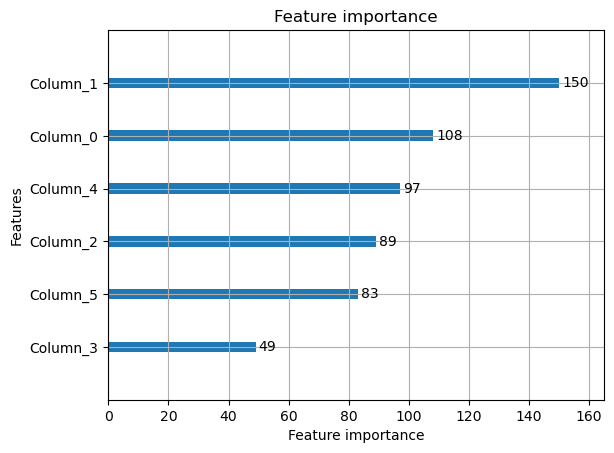

In [29]:
lgb.plot_importance(model)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

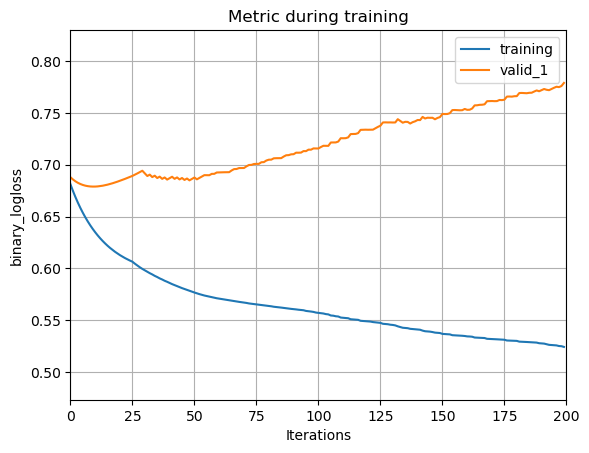

In [30]:
lgb.plot_metric(model)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

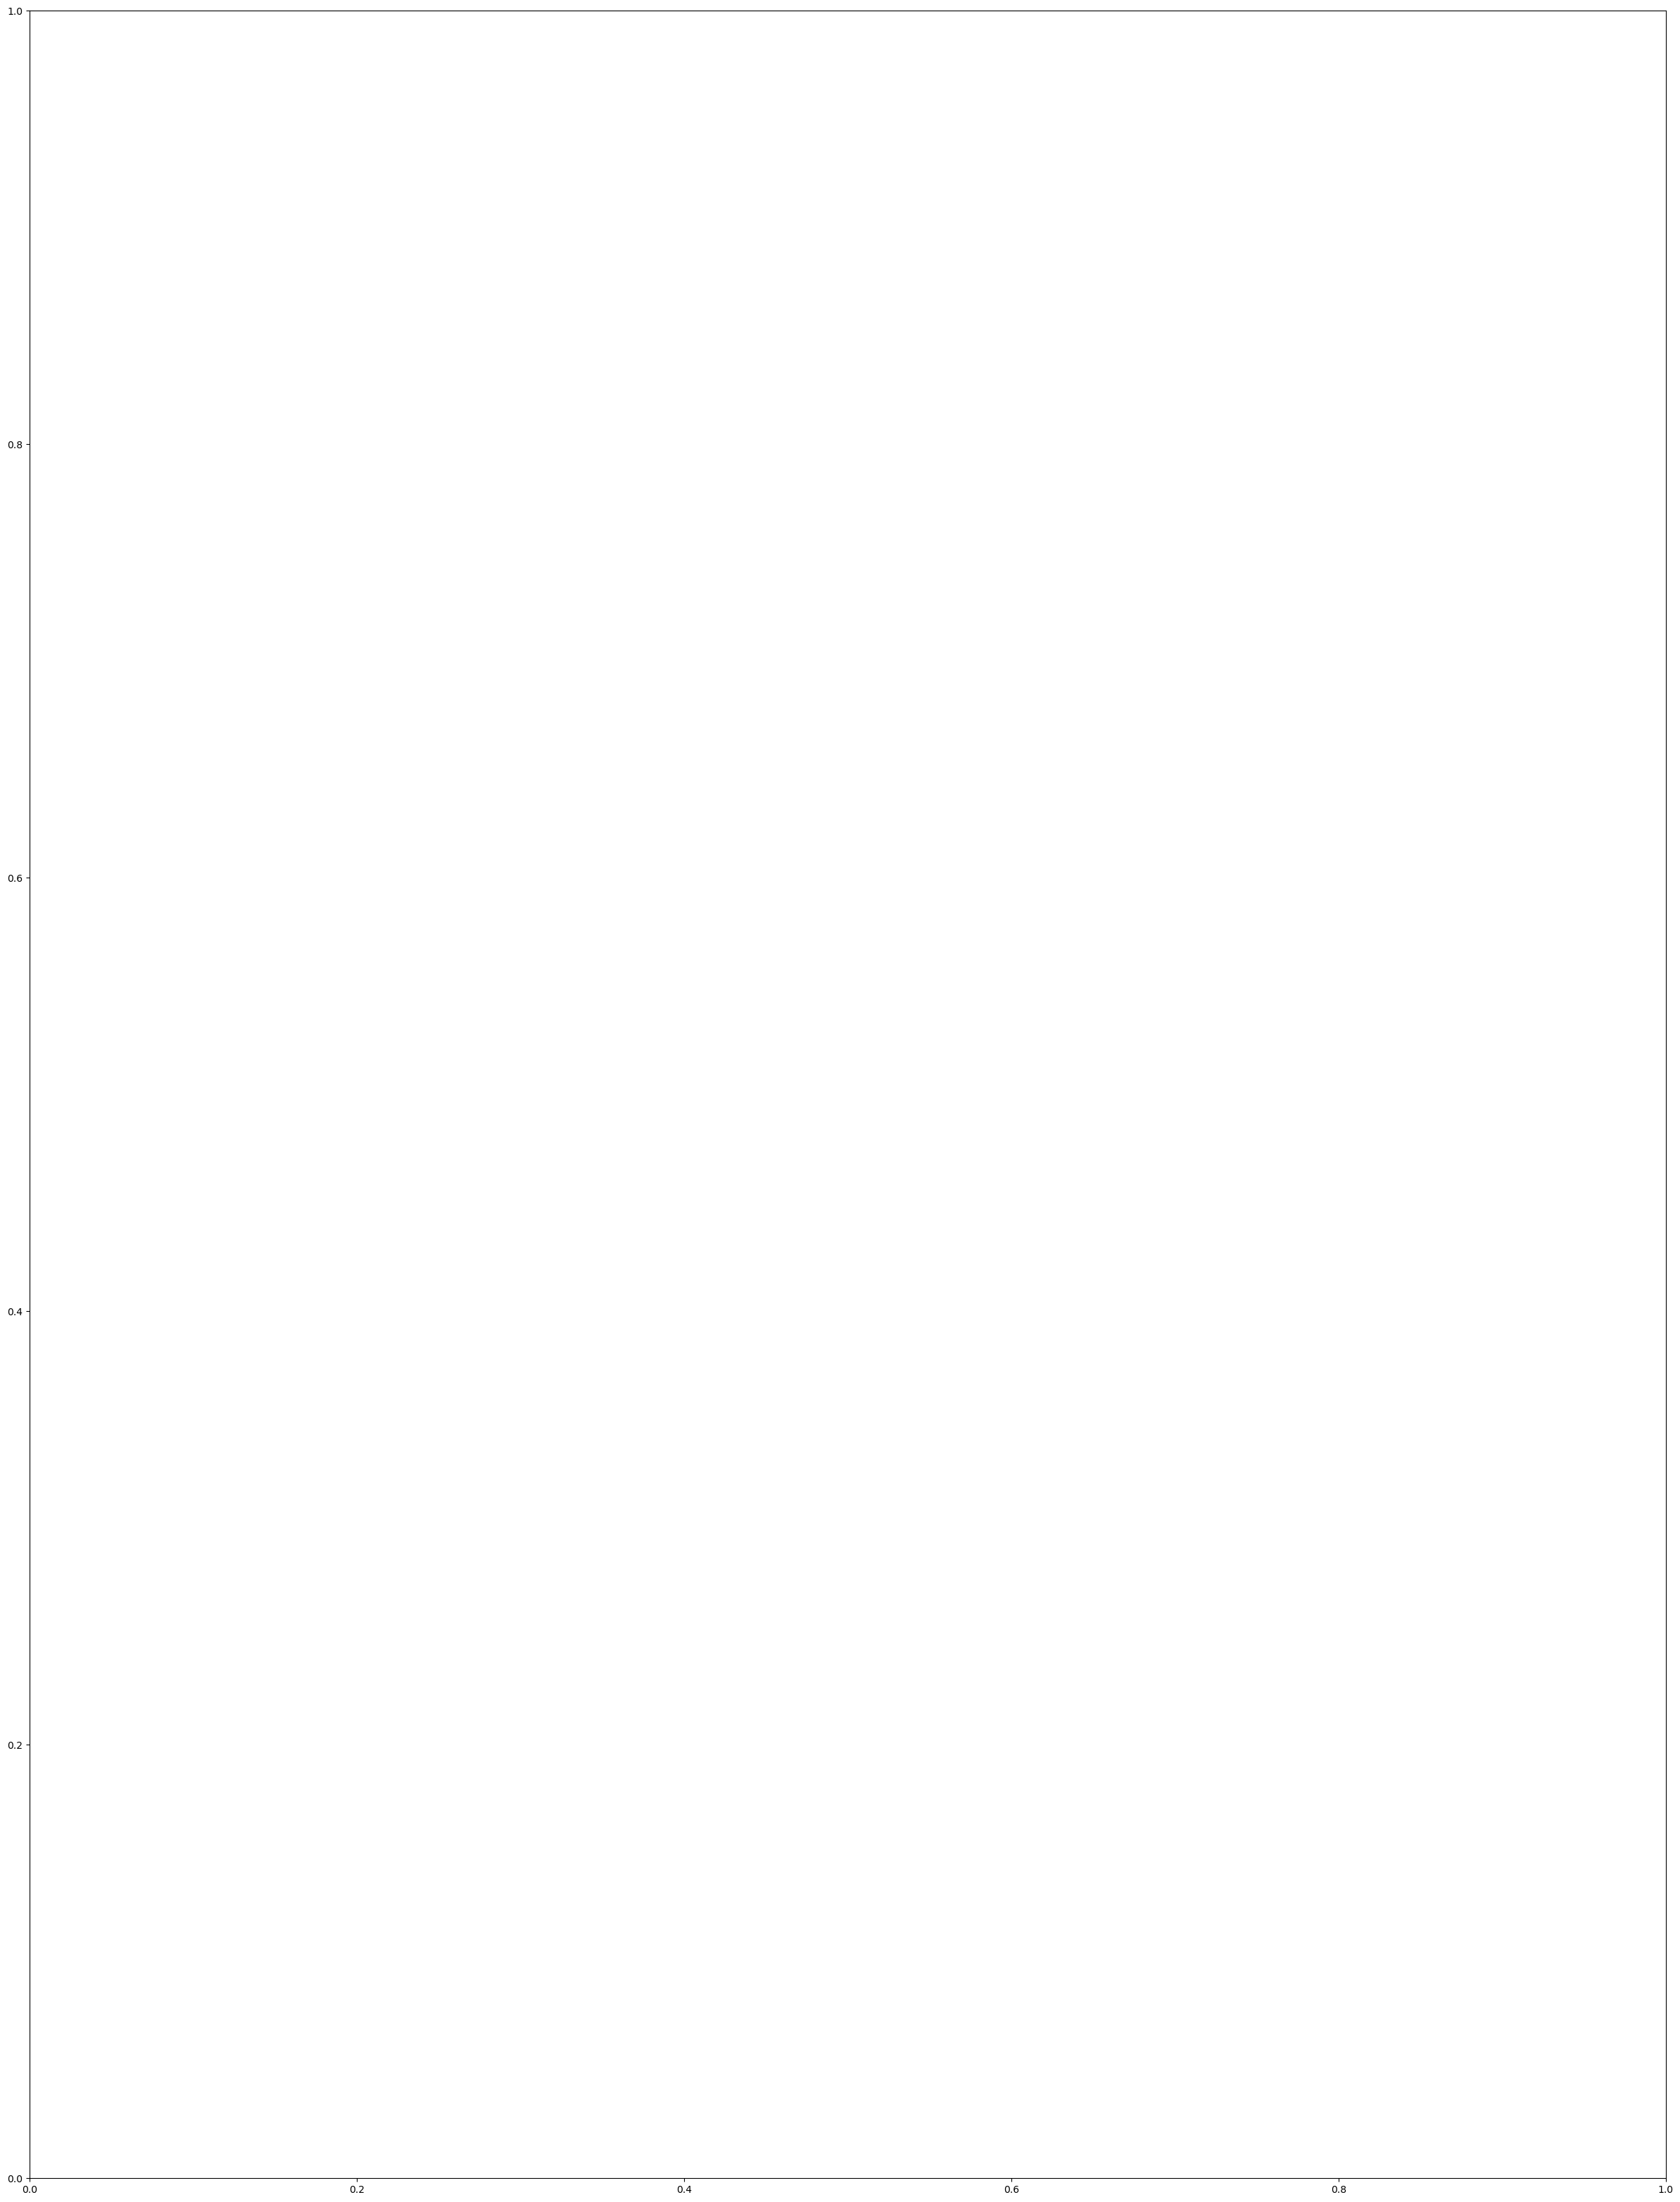

In [16]:
lgb.plot_tree(model,figsize=(30,40))

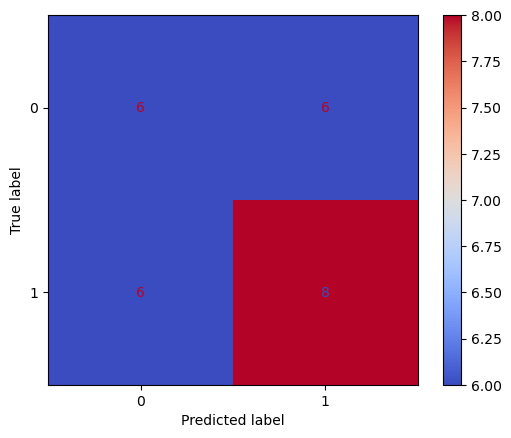

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,cmap='coolwarm')

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        12
           1       0.57      0.57      0.57        14

    accuracy                           0.54        26
   macro avg       0.54      0.54      0.54        26
weighted avg       0.54      0.54      0.54        26



In [ ]:
# score on test set
model.score(X_test,y_test)

In [ ]:
# train the model with the best parameters
best_model = grid_search.best_estimator_

# make predictions
y_pred = best_model.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.2f}')

Load in joblib:

In [ ]:
# models=joblib.load(filename='./joblib/lazypredict_01')

## Statistical Modeling <a name="statistical_modeling"></a>

In [ ]:
import statsmodels.api as sm

In [ ]:
# add constant to our X
X_const=sm.add_constant(df[[col for col in df.columns if col != 'y']])

In [ ]:
# check it out
X_const

In [ ]:
# instantiate the logistic regression model 
logreg = sm.Logit(y, X_const)

# fit the model
logreg_results = logreg.fit()

# display the results 
logreg_results.summary()

All features have p-values above 0.05 except time, which is just under the limit.

In [ ]:
# getting the model predictions as probabilities 
# and saving to 'y_proba'
y_proba = logreg_results.predict(X_const)

# view 
y_proba

In [ ]:
# assume probability >=50%
# is a happy customer prediction
# so we'll make the soft preds into hard preds
y_pred = np.where(y_proba >= 0.5, 1, 0)

# look at the model's predictions
y_pred

In [ ]:
# calculate accuracy
# find where predicted = true survival
# then divide by the number of predictions/passengers
acc = (y_pred == y).sum()/df.shape[0]

# Print the accuracy score
print(f'Model accuracy = {acc}')

In [ ]:
# put params into a dataframe
results_df = pd.DataFrame(logreg_results.params, columns=['Coefficient'])

# view the dataframe
results_df

In [ ]:
# calculate and add the odds ratios to results_df
# log odds is more interpretable
results_df['odds_ratio'] = np.exp(results_df['Coefficient'])

# display the dataframe
results_df

Each component of the survey shows that it has an impact on the overall happiness of the customer. Time is the largest factor, which makes sense: when you're hungry, you want food as soon as possible.

Given that the p-values of time was the only factor that was below the 0.05 threshold suggests that we should try this again with only time as the independent variable.

In [ ]:
# add constant to our X
X_const=sm.add_constant(df[[col for col in df.columns if col != 'y']])

In [ ]:
# check it out
X_const=X_const.drop([col for col in X_const.columns if (col !='a_time') or (col !='const')],axis=1)
X_const

In [ ]:
# instantiate the logistic regression model 
logreg = sm.Logit(y, X_const)

# fit the model
logreg_results = logreg.fit()

# display the results 
logreg_results.summary()

In [ ]:
# getting the model predictions as probabilities 
# and saving to 'y_proba'
y_proba = logreg_results.predict(X_const)

# view 
y_proba

In [ ]:
# assume probability >=50%
# is a happy customer prediction
# so we'll make the soft preds into hard preds
y_pred = np.where(y_proba >= 0.5, 1, 0)

# look at the model's predictions
y_pred

In [ ]:
# calculate accuracy
# find where predicted = true survival
# then divide by the number of predictions/passengers
acc = (y_pred == y).sum()/df.shape[0]

# Print the accuracy score
print(f'Model accuracy = {acc}')

In [ ]:
# put params into a dataframe
results_df = pd.DataFrame(logreg_results.params, columns=['Coefficient'])

# view the dataframe
results_df

In [ ]:
# calculate and add the odds ratios to results_df
# log odds is more interpretable
results_df['odds_ratio'] = np.exp(results_df['Coefficient'])

# display the dataframe
results_df

Oops, that did not work!